Things to check:
1. $\chi^2$ histogram
2. Error histogram
3. Residuals histogram for individual runs
4. Look at longer run

In [13]:
%load_ext autoreload
%autoreload
import sys, os
import numpy as np
import scipy.optimize as optimize
import scipy.fftpack as fft
import scipy.linalg as linalg
from scipy.stats import chisquare
from scipy.stats import linregress

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from BandPass2 import *
from fitFunctions import *
from partialfitting import *
from tqdm import *

import allantools

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 15

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
for i in range(1):
    times = np.arange( 1, 500*1000, 1 )/1000
    sig = 0.39770392*np.sin(2*np.pi*1.554*times) + 0.08523947*np.sin(2*np.pi*15.008*times)
    sig = sig + np.random.normal(0, 1e-6, size=len(sig))
    np.savetxt('/home/jean/RomalisResearch/FakeData/18-12-10/fakedata'+str(i)+".txt", sig)

In [4]:
file = np.loadtxt('/home/jean/RomalisResearch/FakeData/18-12-10/fakedata0.txt')
file = file[:int(np.floor(len(file)/n_ave)*n_ave)]
file = np.mean( file.reshape(-1, n_ave), axis=1 )
times = np.arange( 1, len(file)+1, 1 )*1e-2
Fs = 100
L = len(file)
f = Fs*np.linspace(0, 1, L)
fftdata = np.zeros((2, L))
fftdata[0] = f
fftdata[1] = fft.fft(file)/L

NameError: name 'n_ave' is not defined

(1e-07, 0.1)

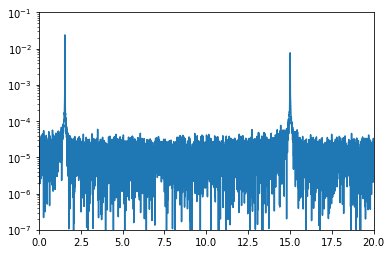

In [216]:
plt.plot(fftdata[0], np.abs(fftdata[1]))
plt.xlim(0,20)
plt.yscale("log")
plt.ylim(1e-7, 1e-1)

In [5]:
#dirName = "/home/jean/RomalisResearch/ncrescini/18-10-30 1/" # Directory with data
dirName = "/home/jean/RomalisResearch/FakeData/18-12-10/" # Directory with data
files = [f for f in os.listdir(dirName) if f.endswith('.txt')]
gHe = 20378.9
gNe = 2*np.pi*336.1
gRatio = gHe/gNe

ks1 = 3 # First file index
ks2 = 3 # Last file index
n_ave = 10 # Number of points to average over

dt = 1e-3*n_ave
Fs = 1/dt
D1Start = 50 # Start of first detection (currently only uses this)
D1EndTimes = [95] # End of first detection (currently only uses this)
D2Start = 200 # Start of second detection (currently doesn't use this)
D2EndTimes = [240] # End of second detection (currently doesn't use this)
curve_fit = True # Use curve_fit or scipy minimize
calcJac = False # Calculate jacobian by hand or extract errors/jacobian from fitter (curve_fit/scipy minimize)
absSigma = True

n_subs_arr = [15] # Number of subsections to break the detection period into

In [147]:
import sys, os
import numpy as np
import scipy.optimize
import scipy.fftpack as fft
import scipy.signal as signal

def BandPassFilter(datafit, dt, paraOut, tCut=100, para2=0):
    nyq = 1/dt/2
    #Combine into a bandpass filter
    d = signal.firwin(1001, np.array([1, 2, 14.5, 15.5]), nyq=nyq, window='blackmanharris', pass_zero=False)
    filtered_sig = signal.lfilter(d, 1.0, datafit[1])
    return [ datafit[0][tCut:], filtered_sig[tCut:] ]

/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


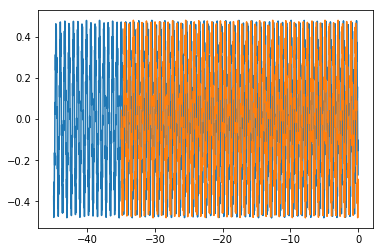

In [150]:
k_ind = 3
bounds_fixfreq = ( ( -3, 3), (-1.5,1.5), (-1,1), (-1,1), (-1, 1), (-1, 1) ) # Bounds for fit if frequency is fixed, for scipy minimize
bounds = ( ( -3, 3), (-1.5,1.5), (0, 3), (-1,1), (-1,1), (10,20), (-1, 1), (-1, 1) ) # Bounds for fit if frequency is not fixed, for scipy minimize

bounds_fixfreq_cf = [ [ -3, -1.5, -1, -1, -1, -1, -1 ], [ 3, 1.5, 1, 1, 1, 1 ] ] # Bounds for fit if frequency is fixed, for curve_fit
bounds_cf = [ [ -3, -1.5, 0, -1, -1, 10, -1, -1 ], [ 3, 1.5, 3, 1, 1, 20, 1, 1 ] ] # Bounds for fit if frequency is not fixed, for curve_fit

paraOut = np.array([1.1, 1.1, 0.5, 0.5, 1e-10, 1e-10 ]) # Initial parameters for fit
data = np.loadtxt(dirName+"/"+files[k_ind])
data = data[:int(np.floor(len(data)/n_ave)*n_ave)]
data = np.mean( data.reshape(-1, n_ave), axis=1 ) # Average data
times = np.arange( 1, len(data)+1, 1 )*dt
DStart = D1Start
DEnd = D1EndTimes[np.mod(k_ind-1,len(D2EndTimes))]
ind_DStart = np.argmin( np.abs(times - DStart) )+1 # Index of start time
ind_DEnd = np.argmin( np.abs(times - DEnd) ) # Index of end time
datafit = np.array([ times[ind_DStart:ind_DEnd] - times[ind_DEnd-1], data[ind_DStart:ind_DEnd] - np.mean(data[ind_DStart:ind_DEnd]) ])
plt.plot(datafit[0], datafit[1])
# Run fit a few times to get initial parameters
paraOut = optimize.minimize( lambda para: least_sq(datafit[1], fitSine2Slope([para[0], para[1], 1.5554, para[2], para[3], 15.008, paraOut[4], paraOut[5]], datafit[0])), [ paraOut[0], paraOut[1], paraOut[2], paraOut[3], paraOut[4], paraOut[5] ], method="SLSQP", bounds=bounds_fixfreq, options={'eps': 1e-12} ).x
paraOut = optimize.minimize( lambda para: least_sq(datafit[1], fitSine2Slope(para, datafit[0])), [ paraOut[0], paraOut[1], 1.5554, paraOut[2], paraOut[3], 15.008, paraOut[4], paraOut[5] ], method="SLSQP", bounds=bounds, options={'eps': 1e-12} ).x
datafit = BandPassFilter(datafit, dt, paraOut, 1000, 2) # Bandpass filter
paraOut = optimize.minimize( lambda para: least_sq(datafit[1], fitSine2Slope(para, datafit[0])), paraOut, method="SLSQP", bounds=bounds, options={'eps': 1e-12} ).x # Run fit again

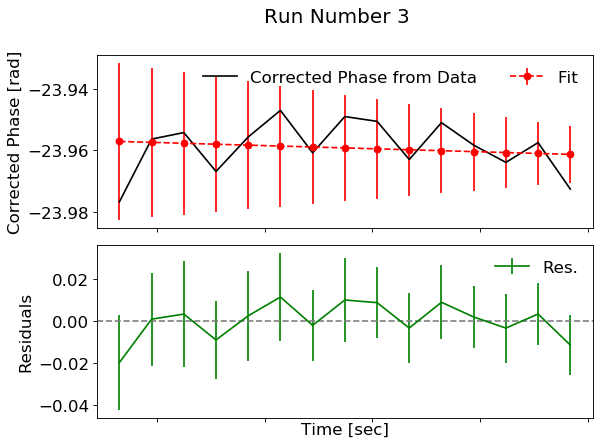

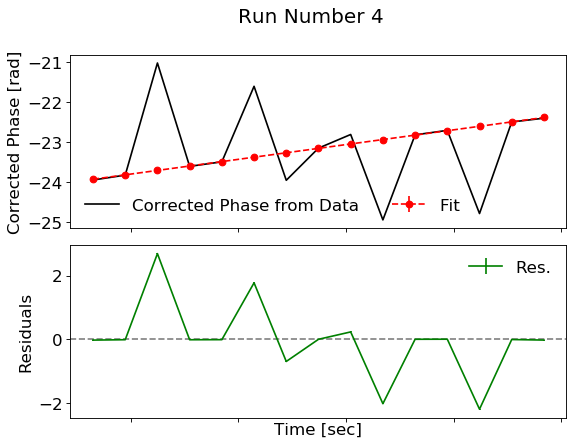

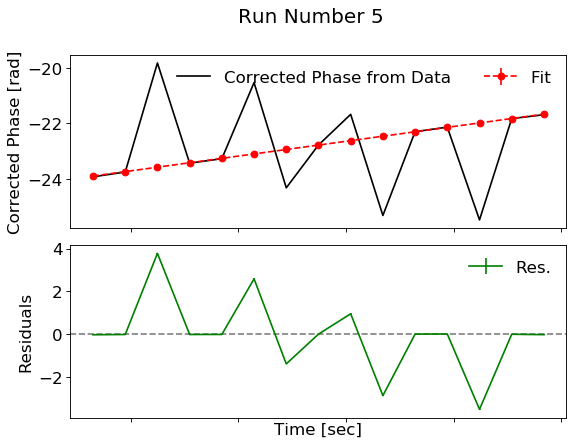

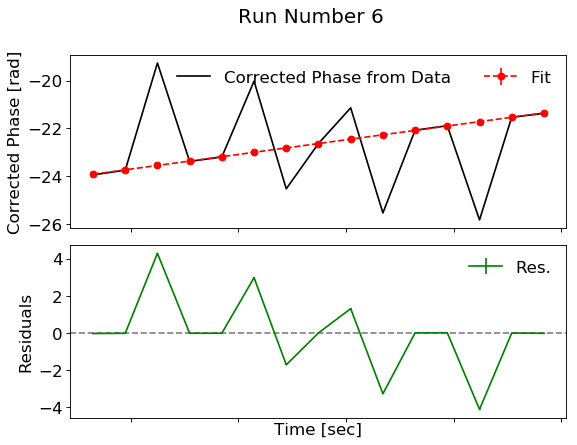

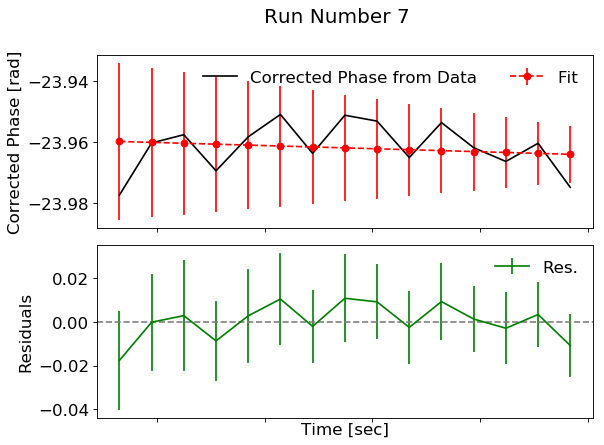

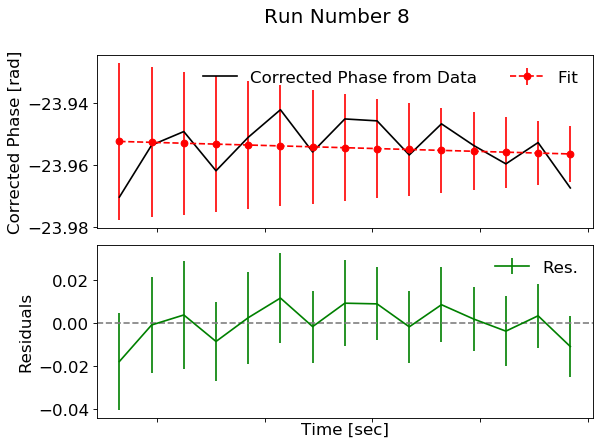

In [616]:
for k_ind in range(ks1, ks2+1):
    i = k_ind - ks1
    if i>5: continue
    plt.figure();
    f, ax_arr = plt.subplots(2, 1)
    f.suptitle("Run Number " + str(k_ind) )
    ax_arr[0].plot( np.mean(dataPar_x, axis=1), phi1_arr_all[i] - r_arr[i]*phi2_arr_all[i], c="black", label="Corrected Phase from Data")
    ax_arr[0].errorbar( np.mean(dataPar_x, axis=1), corrphase_arr[i][1] + np.mean(dataPar_x, axis=1)*corrphase_arr[i][0], np.amax( (np.abs(corrphaseerr_arr[i][1]+corrphaseerr_arr[i][0]*np.mean(dataPar_x, axis=1)), np.abs(corrphaseerr_arr[i][1]-corrphaseerr_arr[i][0]*np.mean(dataPar_x, axis=1))), axis=0), c="red", ls="--", label="Fit", marker="o")
    ax_arr[1].errorbar( np.mean(dataPar_x, axis=1), (phi1_arr_all[i] - r_arr[i]*phi2_arr_all[i] - (corrphase_arr[i][1] + np.mean(dataPar_x, axis=1)*corrphase_arr[i][0])), (errtout_arr[:,5]**2 + (errtout_arr[:,2]*r)**2)**.5, c="green", label="Res.")
    ax_arr[1].axhline(0, ls="--", c="grey")
    ax_arr[0].legend(frameon=False, ncol=2 )
    ax_arr[1].legend(frameon=False, ncol=2 )
    ax_arr[1].set_xlabel("Time [sec]")
    ax_arr[0].set_ylabel("Corrected Phase [rad]")
    ax_arr[1].set_ylabel("Residuals")
    plt.setp([a.get_xticklabels() for a in [f.axes[1], f.axes[0]]], visible=False)
    f.subplots_adjust(hspace=0.1)

In [603]:
        # Make some plots
#         plt.figure()
#         plt.plot(dataPar_x.flatten(), (dataPar_y).flatten())
#         plt.plot(dataPar_x.flatten(), datafit2, ls="--")
#         plt.plot(dataPar_x.flatten(), 100*(datafit2-(dataPar_y).flatten())-1.5)
#         mpl.rcParams['figure.figsize'] = [15.0, 6.0]
#         f, ax_arr = plt.subplots(2, 2)
#         f.suptitle(str(k_ind)+' $\Delta t = '+str(dataPar_x[1,0]-dataPar_x[0,0])+"$, $N_1="+str(N1)+"$, $N_2="+str(N2)+"$")
#         ax_arr[0,0].plot( np.mean(dataPar_x, axis=1), phi1_arr, c="black", label="Phase from Data")
#         ax_arr[0,0].errorbar( np.mean(dataPar_x, axis=1), phi1_fit[1] + np.mean(dataPar_x, axis=1)*phi1_fit[0], (phi1_err[1]+phi1_err[0]*np.mean(dataPar_x, axis=1)), c="red", ls="--", label="Fit")
#         ax_arr[0,0].plot( np.mean(dataPar_x, axis=1), phi1_arr[0]+(np.mean(dataPar_x, axis=1)-np.mean(dataPar_x, axis=1)[0])*freq1, ls="-", c="blue", label="$\omega_{fit}t$")
#         ax_arr[1,0].plot( np.mean(dataPar_x, axis=1), (phi1_arr - (phi1_fit[1] + np.mean(dataPar_x, axis=1)*phi1_fit[0])), c="green", label="Res.")
#         ax_arr[1,0].axhline(0, ls="--", c="grey")
#         ax_arr[0,0].legend(frameon=False, ncol=2 )
#         ax_arr[1,0].legend(frameon=False, ncol=2 )
#         ax_arr[1,0].set_xlabel("Time [sec]")
#         ax_arr[0,0].set_ylabel("Phase [rad]")
#         ax_arr[1,0].set_ylabel("Residuals")
#         f.subplots_adjust(hspace=0)

#         ax_arr[0,1].plot( np.mean(dataPar_x, axis=1), phi2_arr, c="black", label="Phase from Data")
#         ax_arr[0,1].errorbar( np.mean(dataPar_x, axis=1), phi2_fit[1] + np.mean(dataPar_x, axis=1)*phi2_fit[0], (phi2_err[1]+phi2_err[0]*np.mean(dataPar_x, axis=1)), c="red", ls="--", label="Fit")
#         ax_arr[0,1].plot( np.mean(dataPar_x, axis=1), phi2_arr[0]+(np.mean(dataPar_x, axis=1)-np.mean(dataPar_x, axis=1)[0])*freq2, ls="-", c="blue", label="$\omega_{fit}t$")
#         ax_arr[1,1].plot( np.mean(dataPar_x, axis=1), (phi2_arr - (phi2_fit[1] + np.mean(dataPar_x, axis=1)*phi2_fit[0])), c="green", label="Res.")
#         ax_arr[1,1].axhline(0, ls="--", c="grey")
#         ax_arr[0,1].legend(frameon=False, ncol=2 )
#         ax_arr[1,1].legend(frameon=False, ncol=2 )
#         ax_arr[1,1].set_xlabel("Time [sec]")
#         ax_arr[0,1].set_ylabel("Phase [rad]")
#         ax_arr[1,1].set_ylabel("Residuals")
#         plt.setp([a.get_xticklabels() for a in [f.axes[1], f.axes[0]]], visible=False)
#         f.subplots_adjust(hspace=0)

#         plt.figure();
#         f, ax_arr = plt.subplots(2, 1)
#         f.suptitle(str(k_ind))
#         ax_arr[0].errorbar( (np.mean(dataPar_x, axis=1)[:-1]+np.mean(dataPar_x, axis=1)[1:])/2, (phi1_arr[1:]-phi1_arr[:-1])/(dataPar_x[1,0]-dataPar_x[0,0]), np.sqrt(errtout_arr[1:,5]**2+errtout_arr[:-1,5]**2)/(dataPar_x[1,0]-dataPar_x[0,0]), label="$\\frac{\\Delta \\phi}{\\Delta t}$", c="black", ls="--", fmt='o', markersize=8, capsize=8)
#         ax_arr[0].axhline(phi1_fit[0], ls="--", c="grey", label="$\omega_{fit}$")
#         ax_arr[1].errorbar(  (np.mean(dataPar_x, axis=1)[:-1]+np.mean(dataPar_x, axis=1)[1:])/2, (phi2_arr[1:]-phi2_arr[:-1])/(dataPar_x[1,0]-dataPar_x[0,0]), np.sqrt(errtout_arr[1:,2]**2+errtout_arr[:-1,2]**2)/(dataPar_x[1,0]-dataPar_x[0,0]), label="$\\frac{\\Delta \\phi}{\\Delta t}$", c="black", ls="--", fmt='o', markersize=8, capsize=8)
#         ax_arr[1].axhline(phi2_fit[0], ls="--", c="grey", label="$\omega_{fit}$")
#         ax_arr[0].set_ylabel("$\\frac{\\Delta \\phi}{\\Delta t}$ [rad s$^{-1}$]")
#         ax_arr[1].set_ylabel("$\\frac{\\Delta \\phi}{\\Delta t}$ [rad s$^{-1}$]")
#         plt.setp([a.get_xticklabels() for a in [f.axes[0]]], visible=False)
#         f.subplots_adjust(hspace=0)
#         ax_arr[1].set_xlabel("Time [sec]")
#         ax_arr[0].legend()
#         ax_arr[1].legend()

#         plt.figure();
#         f, ax_arr = plt.subplots(2, 1)
#         f.suptitle(str(k_ind))
#         ax_arr[0].errorbar(np.mean(dataPar_x, axis=1)[1:], np.array(fit_freq1)/(2*np.pi), fit_err1, label="$\omega_1(t)$", c="black", ls="--", fmt='o', markersize=8, capsize=8)
#         ax_arr[0].axhline(phi1_fit[0]/(2*np.pi), ls="--", c="grey", label="$\omega_{fit}$")
#         ax_arr[1].errorbar(np.mean(dataPar_x, axis=1)[1:], np.array(fit_freq2)/(2*np.pi), fit_err2, label="$\omega_2(t)$", c="black", ls="--", fmt='o', markersize=8, capsize=8)
#         ax_arr[1].axhline(phi2_fit[0]/(2*np.pi), ls="--", c="grey", label="$\omega_{fit}$")
#         ax_arr[0].set_ylabel("$\omega$ [Hz]")
#         ax_arr[1].set_ylabel("$\omega$ [Hz]")
#         plt.setp([a.get_xticklabels() for a in [f.axes[0]]], visible=False)
#         f.subplots_adjust(hspace=0.1)
#         ax_arr[1].set_xlabel("Time [sec]")
#         ax_arr[0].legend()
#         ax_arr[1].legend()

#         print('-------------------', n_subs, '-------------------')
#         print(phi1_fit[0]/2/np.pi, phi2_fit[0]/2/np.pi)
#         print(freq1/2/np.pi, freq2/2/np.pi)

Text(0.5,0,'Run Number')

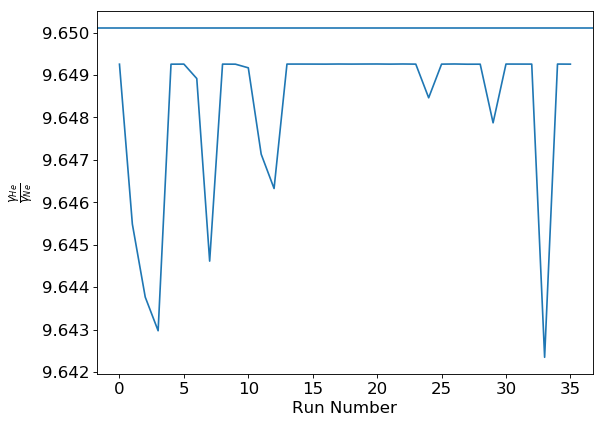

In [607]:
plt.plot(r_arr)
plt.axhline(gHe/gNe)
plt.ylabel("$\\frac{\\gamma_{He}}{\\gamma_{Ne}}$")
plt.xlabel("Run Number")

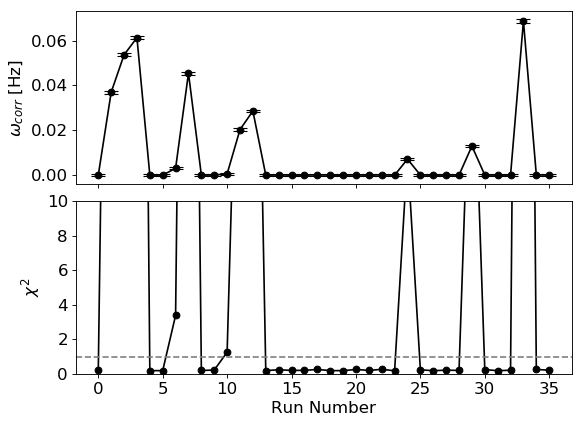

In [610]:
# plt.figure()
# plt.ylabel("Corrected Frequency [Hz]")
# plt.xlabel("Run Number")
# plt.errorbar(np.arange(len(fout)), fout[:,0] - gHe/gNe*fout[:,1], np.sqrt(ferr[:,0]**2 + (ferr[:,1]*gHe/gNe)**2), fmt="o", ls="-", c="black", markersize=6, capsize=6)
# plt.figure()
# plt.ylabel("Frequency Ratio")
# plt.xlabel("Run Number")
# plt.errorbar(np.arange(len(fout)), fout[:,0]/fout[:,1], fout[:,0]/fout[:,1]*np.sqrt((ferr[:,0]/fout[:,0])**2 + (ferr[:,1]/fout[:,1])**2), fmt="o", ls="-", c="black", markersize=6, capsize=6)
# plt.figure()
# f, ax_arr = plt.subplots(2, 1)
# ax_arr[0].errorbar(np.arange(len(fout)), fout[:,0]/(2*np.pi), ferr[:,0]/(2*np.pi), fmt="o", ls="-", c="black", markersize=6, capsize=6)
# ax_arr[0].set_ylabel("$\omega$ [Hz]")
# ax_arr[1].plot(np.arange(len(fout)), chi2[:,0], marker=".", markersize=12, color="black")
# ax_arr[1].set_ylabel("$\chi^2$")
# ax_arr[1].set_xlabel("Run Number")
# ax_arr[1].axhline(1, ls="--", c="grey")
# #ax_arr[1].set_yscale("log")
# plt.setp([a.get_xticklabels() for a in [f.axes[0]]], visible=False)
# f.subplots_adjust(hspace=0.1)
# plt.figure()
# f, ax_arr = plt.subplots(2, 1)
# ax_arr[0].errorbar(np.arange(len(fout)), fout[:,1]/(2*np.pi), ferr[:,1]/(2*np.pi), fmt="o", ls="-", c="black", markersize=6, capsize=6)
# ax_arr[0].set_ylabel("$\omega$ [Hz]")
# ax_arr[1].plot(np.arange(len(fout)), chi2[:,1], marker=".", markersize=12, color="black")
# ax_arr[1].set_ylabel("$\chi^2$")
# ax_arr[1].set_xlabel("Run Number")
# ax_arr[1].axhline(1, ls="--", c="grey")
# #ax_arr[1].set_yscale("log")
# plt.setp([a.get_xticklabels() for a in [f.axes[0]]], visible=False)
# f.subplots_adjust(hspace=0.1)
f, ax_arr = plt.subplots(2, 1)
ax_arr[0].errorbar(np.arange(len(corrphase_arr)), corrphase_arr[:,0], corrphaseerr_arr[:,0], fmt="o", ls="-", c="black", markersize=6, capsize=6)
ax_arr[0].set_ylabel("$\omega_{corr}$ [Hz]")
ax_arr[1].plot(np.arange(len(corrphase_arr)), corrphasechi2_arr, marker=".", markersize=12, color="black")
ax_arr[1].set_ylabel("$\chi^2$")
ax_arr[1].set_xlabel("Run Number")
ax_arr[1].axhline(1, ls="--", c="grey")
ax_arr[1].set_ylim(0,10)
#ax_arr[1].set_yscale("log")
plt.setp([a.get_xticklabels() for a in [f.axes[0]]], visible=False)
f.subplots_adjust(hspace=0.1)

Text(0.5,1,'$\\omega_{corr} \\, \\chi^2$ histogram')

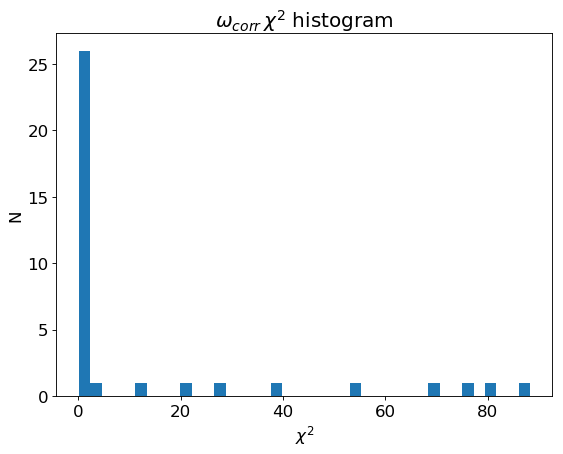

In [606]:
plt.hist(corrphasechi2_arr, bins=40)
plt.xlabel("$\chi^2$")
plt.ylabel("N")
plt.title("$\omega_{corr} \, \chi^2$ histogram")

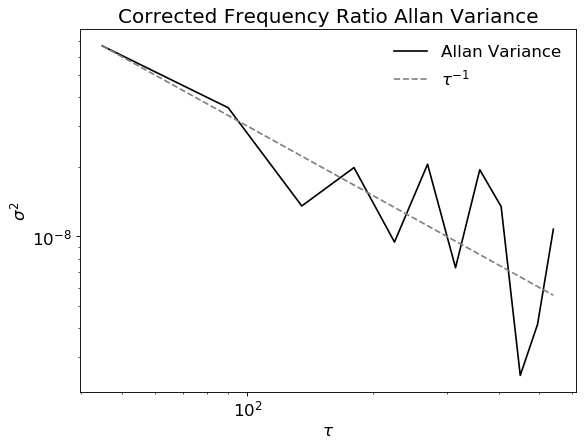

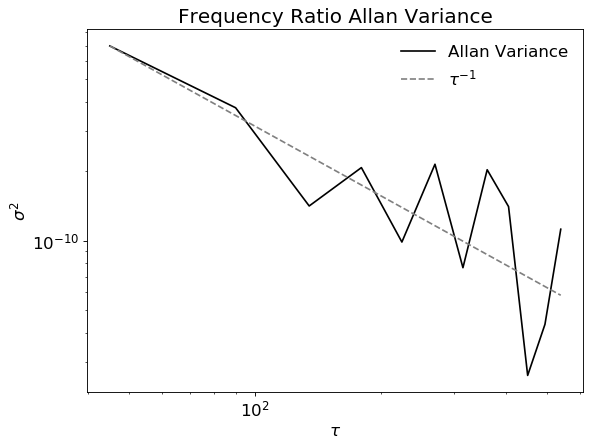

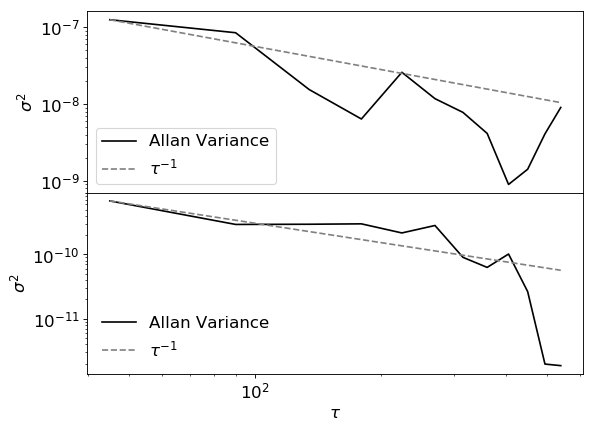

In [120]:
(t2, ad, ade, adn) = allantools.adev(fout[:,0] - gHe/gNe*fout[:,1], rate=1/(D1EndTimes[0]-D1Start), data_type="freq", taus=np.arange(len(fout))*(D1EndTimes[0]-D1Start))
plt.title("Corrected Frequency Ratio Allan Variance")
plt.plot(t2, ad**2, label="Allan Variance", c="black")
plt.plot(t2, ad[0]**2*t2[0]/t2, label="$\\tau^{-1}$", c="grey", ls="--")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("$\sigma^2$")
plt.xlabel("$\\tau$")
plt.legend(frameon=False)

plt.figure()
plt.title("Frequency Ratio Allan Variance")
(t2, ad, ade, adn) = allantools.adev(fout[:,0]/fout[:,1], rate=1/(D1EndTimes[0]-D1Start), data_type="freq", taus=np.arange(len(fout))*(D1EndTimes[0]-D1Start))
plt.plot(t2, ad**2, label="Allan Variance", c="black")
plt.plot(t2, ad[0]**2*t2[0]/t2, label="$\\tau^{-1}$", c="grey", ls="--")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("$\sigma^2$")
plt.xlabel("$\\tau$")
plt.legend(frameon=False)

plt.figure()
f, ax_arr = plt.subplots(2, 1)
(t2, ad, ade, adn) = allantools.adev(fout[:,0], rate=1/(D1EndTimes[0]-D1Start), data_type="freq", taus=np.arange(len(fout))*(D1EndTimes[0]-D1Start))
ax_arr[0].plot(t2, ad**2, label="Allan Variance", c="black")
ax_arr[0].plot(t2, ad[0]**2*t2[0]/t2, label="$\\tau^{-1}$", c="grey", ls="--")
ax_arr[0].set_yscale("log")
ax_arr[0].set_xscale("log")
ax_arr[0].set_ylabel("$\sigma^2$")
ax_arr[0].set_xlabel("$\\tau$")
ax_arr[0].legend()
(t2, ad, ade, adn) = allantools.adev(fout[:,1], rate=1/(D1EndTimes[0]-D1Start), data_type="freq", taus=np.arange(len(fout))*(D1EndTimes[0]-D1Start))
ax_arr[1].plot(t2, ad**2, label="Allan Variance", c="black")
ax_arr[1].plot(t2, ad[0]**2*t2[0]/t2, label="$\\tau^{-1}$", c="grey", ls="--")
ax_arr[1].set_yscale("log")
ax_arr[1].set_xscale("log")
ax_arr[1].set_ylabel("$\sigma^2$")
ax_arr[1].set_xlabel("$\\tau$")
ax_arr[1].legend(frameon=False)
plt.setp(f.axes[0].get_xticklabels(), visible=False)
f.subplots_adjust(hspace=0.)